# Code to mask the labels in the image so as to remove any kind of bias that can exist in the classifier
# This code is run by first creating a python conda environment. Add these modules to run the code, 
## module load tensorflow/2.11.0
## module load gcc/12.2.0
## module load bazel/4.1.0
## module load cuda/11.2
## module load cudnn/8.1.1

# Use this to check if tensorflow is detecting the GPU

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10270735975264047039
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15332474880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2507742371455655438
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:18:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.11.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Check the results of the kerasOCR pipeline and check if it's creating the right bounding boxes

Looking for /usr4/ds549/rithik/.keras-ocr/craft_mlt_25k.h5
Looking for /usr4/ds549/rithik/.keras-ocr/crnn_kurapan.h5
/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/secondary_task/check/18327.jpg
/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/secondary_task/check/19993.jpg
/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/secondary_task/check/14995.jpg
/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/secondary_task/check/16661.jpg


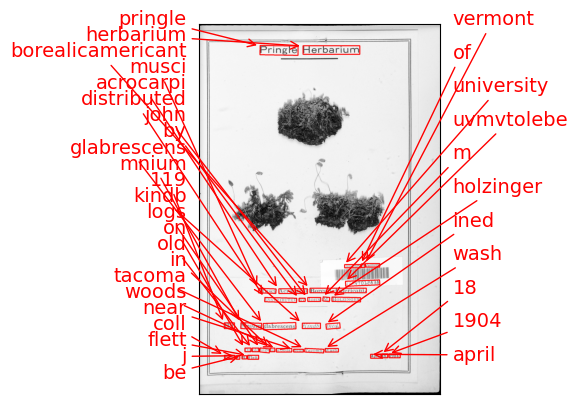

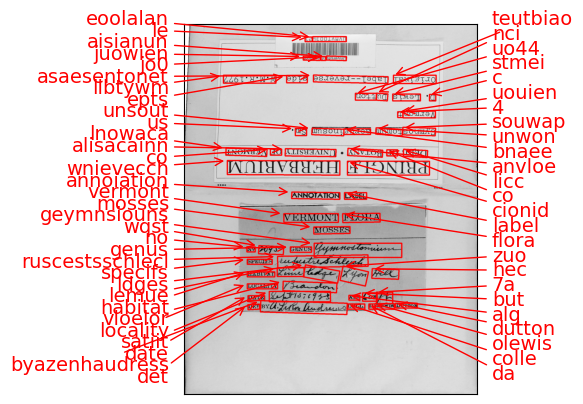

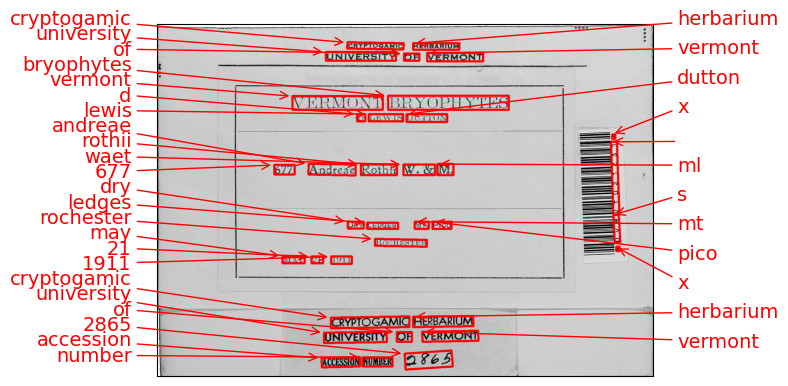

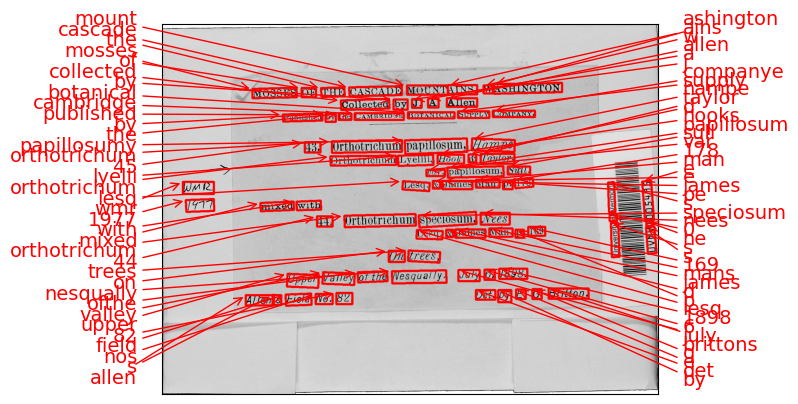

In [8]:
import os
image_folder = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/secondary_task/check/"
import matplotlib.pyplot as plt
import keras_ocr



pipeline = keras_ocr.pipeline.Pipeline()
for file in os.listdir(image_folder):
    #read image from the an image path (a jpg/png file or an image url)
    file_path = os.path.join(image_folder, file)
    img = keras_ocr.tools.read(file_path)
    # Prediction_groups is a list of (word, box) tuples
    prediction_groups = pipeline.recognize([img])
    #print image with annotation and boxes
    keras_ocr.tools.drawAnnotations(image=img, predictions=prediction_groups[0])

# Use the keras OCR pipeline and remove text from the masked regions. (Note: you can perform OpenCV's inpainting function if you have cuda acceleration set up with OpenCV, at the time not available for inpainting)

In [7]:
import os
import multiprocessing as mp
from tqdm import tqdm
import cv2
import math
import numpy as np
import keras_ocr
import time
from PIL import Image
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)


NUM_CORES = min(mp.cpu_count(), 50)
image_folder = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/secondary_task/images/20230402-114028/"
pipeline = keras_ocr.pipeline.Pipeline()


start_time = time.time()

def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

def remove_text(file,pipeline):
    file_path = os.path.join(image_folder, file)
    # read image
    img = keras_ocr.tools.read(file_path)
    # generate (word, box) tuples 
    prediction_groups = pipeline.recognize([img])   
        
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 

        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mid1 = midpoint(x0, y0, x3, y3)

        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))

        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mid1), 255, thickness)

    # set masked pixels to zero
    img[mask != 0] = 0
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(file_path, img_rgb)
        

error_keys=[]        
file_names = sorted(os.listdir(image_folder), key=lambda x: int(x.split('.')[0]))
for file in tqdm(file_names[48000:88000]):
    try:
        remove_text(file,pipeline)
    except Exception as e:
        error_keys.append(file)
        print(f"Error processing file {file}: {e}")

end_time = time.time()

total_time = end_time - start_time

print(f"Total time taken: {total_time:.2f} seconds") 
print("image text detection failures", error_keys)

Looking for /usr4/ds549/rithik/.keras-ocr/craft_mlt_25k.h5
Looking for /usr4/ds549/rithik/.keras-ocr/crnn_kurapan.h5


  0%|                                                 | 0/40000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 388ms/step


  0%|                                       | 1/40000 [00:00<8:57:10,  1.24it/s]

1/1 [==============================] - 0s 409ms/step


  0%|                                       | 2/40000 [00:01<8:41:00,  1.28it/s]

1/1 [==============================] - 0s 37ms/step


  0%|                                       | 3/40000 [00:01<6:35:04,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


  0%|                                       | 4/40000 [00:02<5:37:32,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


  0%|                                       | 5/40000 [00:02<5:18:50,  2.09it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                       | 6/40000 [00:03<5:01:21,  2.21it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                       | 7/40000 [00:03<4:46:04,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


  0%|                                       | 8/40000 [00:03<4:34:52,  2.42it/s]

1/1 [==============================] - 0s 447ms/step


  0%|                                       | 9/40000 [00:04<6:19:32,  1.76it/s]

1/1 [==============================] - 0s 63ms/step


  0%|                                      | 10/40000 [00:05<5:49:47,  1.91it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                      | 11/40000 [00:05<5:15:15,  2.11it/s]

1/1 [==============================] - 0s 41ms/step


  0%|                                      | 12/40000 [00:05<4:56:51,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


  0%|                                      | 13/40000 [00:06<4:39:08,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


  0%|                                      | 14/40000 [00:06<4:26:18,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


  0%|                                      | 15/40000 [00:07<4:26:07,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


  0%|                                      | 16/40000 [00:07<4:21:22,  2.55it/s]

1/1 [==============================] - 1s 1s/step


  0%|                                      | 17/40000 [00:09<8:40:44,  1.28it/s]

1/1 [==============================] - 0s 30ms/step


  0%|                                      | 18/40000 [00:09<7:24:44,  1.50it/s]

1/1 [==============================] - 0s 35ms/step


  0%|                                      | 19/40000 [00:09<6:39:43,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                      | 20/40000 [00:10<6:30:04,  1.71it/s]

1/1 [==============================] - 0s 53ms/step


  0%|                                      | 21/40000 [00:11<6:22:43,  1.74it/s]

1/1 [==============================] - 0s 40ms/step


  0%|                                      | 22/40000 [00:11<5:46:14,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                      | 23/40000 [00:11<5:15:22,  2.11it/s]

1/1 [==============================] - 0s 34ms/step


  0%|                                      | 24/40000 [00:12<4:57:27,  2.24it/s]

1/1 [==============================] - 0s 42ms/step


  0%|                                      | 25/40000 [00:12<4:55:38,  2.25it/s]

1/1 [==============================] - 0s 32ms/step


  0%|                                      | 26/40000 [00:13<4:47:12,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


  0%|                                      | 27/40000 [00:13<4:40:49,  2.37it/s]

1/1 [==============================] - 0s 52ms/step


  0%|                                      | 28/40000 [00:13<4:43:37,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


  0%|                                      | 29/40000 [00:14<5:00:57,  2.21it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                      | 30/40000 [00:14<4:51:56,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


  0%|                                      | 31/40000 [00:15<4:51:52,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


  0%|                                      | 32/40000 [00:15<4:36:50,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


  0%|                                      | 33/40000 [00:15<4:17:40,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


  0%|                                      | 34/40000 [00:16<4:20:47,  2.55it/s]

1/1 [==============================] - 0s 52ms/step


  0%|                                      | 35/40000 [00:16<4:30:33,  2.46it/s]

1/1 [==============================] - 0s 49ms/step


  0%|                                      | 36/40000 [00:17<4:45:09,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


  0%|                                      | 37/40000 [00:17<4:44:44,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


  0%|                                      | 38/40000 [00:18<4:46:31,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                      | 39/40000 [00:18<4:40:24,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


  0%|                                      | 40/40000 [00:19<5:06:10,  2.18it/s]

1/1 [==============================] - 0s 33ms/step


  0%|                                      | 41/40000 [00:19<5:08:33,  2.16it/s]

1/1 [==============================] - 0s 34ms/step


  0%|                                      | 42/40000 [00:20<5:07:00,  2.17it/s]

1/1 [==============================] - 0s 23ms/step


  0%|                                      | 43/40000 [00:20<5:15:58,  2.11it/s]

1/1 [==============================] - 0s 53ms/step


  0%|                                      | 44/40000 [00:20<5:02:11,  2.20it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                      | 45/40000 [00:21<4:52:50,  2.27it/s]

1/1 [==============================] - 0s 23ms/step


  0%|                                      | 46/40000 [00:21<4:58:44,  2.23it/s]

1/1 [==============================] - 0s 61ms/step


  0%|                                      | 47/40000 [00:22<5:01:08,  2.21it/s]

1/1 [==============================] - 0s 36ms/step


  0%|                                      | 48/40000 [00:22<4:54:48,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


  0%|                                      | 49/40000 [00:23<5:03:59,  2.19it/s]

1/1 [==============================] - 0s 24ms/step


  0%|                                      | 50/40000 [00:23<5:09:32,  2.15it/s]

1/1 [==============================] - 0s 29ms/step


  0%|                                      | 51/40000 [00:23<4:33:10,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                      | 52/40000 [00:24<4:35:41,  2.42it/s]

1/1 [==============================] - 0s 43ms/step


  0%|                                      | 53/40000 [00:24<4:49:19,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


  0%|                                      | 54/40000 [00:25<4:50:53,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                      | 55/40000 [00:25<4:40:22,  2.37it/s]

1/1 [==============================] - 0s 50ms/step


  0%|                                      | 56/40000 [00:26<4:31:27,  2.45it/s]

1/1 [==============================] - 0s 58ms/step


  0%|                                      | 57/40000 [00:26<4:35:43,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                      | 58/40000 [00:26<4:30:08,  2.46it/s]

1/1 [==============================] - 0s 26ms/step


  0%|                                      | 59/40000 [00:27<4:43:06,  2.35it/s]

1/1 [==============================] - 0s 51ms/step


  0%|                                      | 60/40000 [00:27<4:43:02,  2.35it/s]

1/1 [==============================] - 0s 56ms/step


  0%|                                      | 61/40000 [00:28<4:50:13,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


  0%|                                      | 62/40000 [00:28<4:54:01,  2.26it/s]

1/1 [==============================] - 0s 24ms/step


  0%|                                      | 63/40000 [00:29<5:05:27,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


  0%|                                      | 64/40000 [00:29<5:00:48,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


  0%|                                      | 65/40000 [00:30<4:51:46,  2.28it/s]

1/1 [==============================] - 0s 71ms/step


  0%|                                      | 66/40000 [00:30<4:50:33,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


  0%|                                      | 67/40000 [00:30<4:49:02,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


  0%|                                      | 68/40000 [00:31<5:13:48,  2.12it/s]

1/1 [==============================] - 0s 59ms/step


  0%|                                      | 69/40000 [00:31<5:11:45,  2.13it/s]

1/1 [==============================] - 0s 40ms/step


  0%|                                      | 70/40000 [00:32<5:05:33,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


  0%|                                      | 71/40000 [00:32<4:49:23,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


  0%|                                      | 72/40000 [00:33<4:41:35,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


  0%|                                      | 73/40000 [00:33<4:44:39,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


  0%|                                      | 74/40000 [00:34<4:56:13,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


  0%|                                      | 75/40000 [00:34<4:50:57,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                      | 76/40000 [00:35<5:19:39,  2.08it/s]

1/1 [==============================] - 0s 41ms/step


  0%|                                      | 77/40000 [00:35<5:09:31,  2.15it/s]

1/1 [==============================] - 0s 42ms/step


  0%|                                      | 78/40000 [00:35<4:58:03,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


  0%|                                      | 79/40000 [00:36<4:54:48,  2.26it/s]

1/1 [==============================] - 0s 56ms/step


  0%|                                      | 80/40000 [00:36<4:53:56,  2.26it/s]

1/1 [==============================] - 0s 58ms/step


  0%|                                      | 81/40000 [00:37<4:57:06,  2.24it/s]

1/1 [==============================] - 0s 23ms/step


  0%|                                      | 82/40000 [00:37<5:06:15,  2.17it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                      | 83/40000 [00:38<4:58:54,  2.23it/s]

1/1 [==============================] - 0s 34ms/step


  0%|                                      | 84/40000 [00:38<5:01:23,  2.21it/s]

1/1 [==============================] - 0s 31ms/step


  0%|                                      | 85/40000 [00:39<4:57:52,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


  0%|                                      | 86/40000 [00:39<4:50:29,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


  0%|                                      | 87/40000 [00:39<4:38:27,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                      | 88/40000 [00:40<4:44:44,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


  0%|                                      | 89/40000 [00:40<4:33:57,  2.43it/s]

1/1 [==============================] - 0s 23ms/step


  0%|                                      | 90/40000 [00:41<4:44:17,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


  0%|                                      | 91/40000 [00:41<4:38:30,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


  0%|                                      | 92/40000 [00:41<4:43:36,  2.35it/s]

1/1 [==============================] - 0s 47ms/step


  0%|                                      | 93/40000 [00:42<5:13:08,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


  0%|                                      | 94/40000 [00:42<5:01:19,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


  0%|                                      | 95/40000 [00:43<4:59:58,  2.22it/s]

1/1 [==============================] - 0s 23ms/step


  0%|                                      | 96/40000 [00:43<5:00:23,  2.21it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                      | 97/40000 [00:44<4:47:29,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                      | 98/40000 [00:44<4:46:05,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


  0%|                                      | 99/40000 [00:45<4:37:15,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


  0%|                                     | 100/40000 [00:45<4:35:55,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


  0%|                                     | 101/40000 [00:45<4:33:49,  2.43it/s]

1/1 [==============================] - 0s 27ms/step


  0%|                                     | 102/40000 [00:46<3:58:17,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


  0%|                                     | 103/40000 [00:46<4:08:13,  2.68it/s]

1/1 [==============================] - 0s 25ms/step


  0%|                                     | 104/40000 [00:46<4:23:36,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


  0%|                                     | 105/40000 [00:47<4:38:16,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                     | 106/40000 [00:47<4:47:23,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


  0%|                                     | 107/40000 [00:48<5:07:27,  2.16it/s]

1/1 [==============================] - 0s 43ms/step


  0%|                                     | 108/40000 [00:48<5:07:18,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


  0%|                                     | 109/40000 [00:49<5:35:42,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


  0%|                                     | 110/40000 [00:49<5:25:56,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


  0%|                                     | 111/40000 [00:50<5:06:07,  2.17it/s]

1/1 [==============================] - 0s 40ms/step


  0%|                                     | 112/40000 [00:50<5:02:05,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


  0%|                                     | 113/40000 [00:51<4:59:38,  2.22it/s]

1/1 [==============================] - 0s 32ms/step


  0%|                                     | 114/40000 [00:51<4:54:55,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


  0%|                                     | 115/40000 [00:52<4:53:50,  2.26it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                     | 116/40000 [00:52<4:49:52,  2.29it/s]

1/1 [==============================] - 0s 54ms/step


  0%|                                     | 117/40000 [00:52<4:48:27,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                     | 118/40000 [00:53<4:47:28,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


  0%|                                     | 119/40000 [00:53<4:33:52,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


  0%|                                     | 120/40000 [00:54<4:42:21,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


  0%|                                     | 121/40000 [00:54<4:49:51,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


  0%|                                     | 122/40000 [00:55<4:42:27,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                     | 123/40000 [00:55<5:20:40,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


  0%|                                     | 124/40000 [00:56<5:12:36,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


  0%|                                     | 125/40000 [00:56<5:12:32,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                     | 126/40000 [00:56<4:59:48,  2.22it/s]

1/1 [==============================] - 0s 44ms/step


  0%|                                     | 127/40000 [00:57<5:18:47,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


  0%|                                     | 128/40000 [00:57<5:06:04,  2.17it/s]

1/1 [==============================] - 0s 44ms/step


  0%|                                     | 129/40000 [00:58<5:05:02,  2.18it/s]

1/1 [==============================] - 0s 41ms/step


  0%|                                     | 130/40000 [00:58<5:03:31,  2.19it/s]

1/1 [==============================] - 0s 32ms/step


  0%|                                     | 131/40000 [00:59<4:54:54,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


  0%|                                     | 132/40000 [00:59<4:47:38,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


  0%|                                     | 133/40000 [01:00<4:38:41,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


  0%|                                     | 134/40000 [01:00<4:39:49,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                     | 135/40000 [01:00<4:40:34,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


  0%|▏                                    | 136/40000 [01:01<4:33:13,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


  0%|▏                                    | 137/40000 [01:01<5:06:12,  2.17it/s]

1/1 [==============================] - 0s 29ms/step


  0%|▏                                    | 138/40000 [01:02<4:49:27,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


  0%|▏                                    | 139/40000 [01:02<4:48:32,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▏                                    | 140/40000 [01:03<4:39:40,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                    | 141/40000 [01:03<4:47:48,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▏                                    | 142/40000 [01:03<4:44:54,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


  0%|▏                                    | 143/40000 [01:04<4:34:12,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▏                                    | 144/40000 [01:04<4:30:13,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▏                                    | 145/40000 [01:05<4:36:32,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


  0%|▏                                    | 146/40000 [01:05<4:56:27,  2.24it/s]

1/1 [==============================] - 0s 46ms/step


  0%|▏                                    | 147/40000 [01:06<4:49:40,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


  0%|▏                                    | 148/40000 [01:06<4:45:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                    | 149/40000 [01:06<4:38:08,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                    | 150/40000 [01:07<4:36:32,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                    | 151/40000 [01:07<4:34:39,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                    | 152/40000 [01:08<4:31:24,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


  0%|▏                                    | 153/40000 [01:08<4:39:02,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▏                                    | 154/40000 [01:08<4:35:13,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▏                                    | 155/40000 [01:09<4:31:45,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


  0%|▏                                    | 156/40000 [01:09<4:31:53,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


  0%|▏                                    | 157/40000 [01:10<4:41:42,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


  0%|▏                                    | 158/40000 [01:10<4:47:06,  2.31it/s]

1/1 [==============================] - 0s 23ms/step


  0%|▏                                    | 159/40000 [01:11<4:54:40,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


  0%|▏                                    | 160/40000 [01:11<5:11:13,  2.13it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▏                                    | 161/40000 [01:12<4:57:56,  2.23it/s]

1/1 [==============================] - 0s 38ms/step


  0%|▏                                    | 162/40000 [01:12<4:51:56,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▏                                    | 163/40000 [01:12<4:51:14,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▏                                    | 164/40000 [01:13<4:39:30,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▏                                    | 165/40000 [01:13<4:43:19,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                    | 166/40000 [01:14<4:40:00,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                    | 167/40000 [01:14<4:31:23,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


  0%|▏                                    | 168/40000 [01:14<4:33:28,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▏                                    | 169/40000 [01:15<4:38:45,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


  0%|▏                                    | 170/40000 [01:15<5:04:36,  2.18it/s]

1/1 [==============================] - 0s 23ms/step


  0%|▏                                    | 171/40000 [01:16<5:03:34,  2.19it/s]

1/1 [==============================] - 0s 35ms/step


  0%|▏                                    | 172/40000 [01:16<5:00:47,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▏                                    | 173/40000 [01:17<4:57:44,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


  0%|▏                                    | 174/40000 [01:17<4:57:31,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▏                                    | 175/40000 [01:18<4:47:03,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


  0%|▏                                    | 176/40000 [01:18<4:46:57,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


  0%|▏                                    | 177/40000 [01:18<4:49:54,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


  0%|▏                                    | 178/40000 [01:19<4:44:38,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


  0%|▏                                    | 179/40000 [01:19<4:39:14,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


  0%|▏                                    | 180/40000 [01:20<4:43:52,  2.34it/s]

1/1 [==============================] - 0s 49ms/step


  0%|▏                                    | 181/40000 [01:20<4:40:22,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


  0%|▏                                    | 182/40000 [01:21<4:36:52,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


  0%|▏                                    | 183/40000 [01:21<4:34:18,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


  0%|▏                                    | 184/40000 [01:21<4:18:26,  2.57it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                    | 185/40000 [01:22<4:20:03,  2.55it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▏                                    | 186/40000 [01:22<4:19:31,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


  0%|▏                                    | 187/40000 [01:23<4:29:30,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▏                                    | 188/40000 [01:23<4:25:07,  2.50it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                    | 189/40000 [01:23<4:17:23,  2.58it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▏                                    | 190/40000 [01:24<4:28:34,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


  0%|▏                                    | 191/40000 [01:24<4:48:34,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


  0%|▏                                    | 192/40000 [01:25<4:54:06,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


  0%|▏                                    | 193/40000 [01:25<4:53:12,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▏                                    | 194/40000 [01:26<4:57:58,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


  0%|▏                                    | 195/40000 [01:26<5:11:23,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


  0%|▏                                    | 196/40000 [01:27<5:19:34,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


  0%|▏                                    | 197/40000 [01:27<5:28:39,  2.02it/s]

1/1 [==============================] - 0s 39ms/step


  0%|▏                                    | 198/40000 [01:28<5:15:03,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


  0%|▏                                    | 199/40000 [01:28<5:03:31,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                    | 200/40000 [01:28<4:55:41,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏                                    | 201/40000 [01:29<4:44:10,  2.33it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▏                                    | 202/40000 [01:29<5:12:47,  2.12it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏                                    | 203/40000 [01:30<4:52:59,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏                                    | 204/40000 [01:30<4:55:03,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏                                    | 205/40000 [01:31<4:44:13,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏                                    | 206/40000 [01:31<4:52:08,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏                                    | 207/40000 [01:32<5:02:32,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏                                    | 208/40000 [01:32<4:59:32,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏                                    | 209/40000 [01:32<5:01:31,  2.20it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏                                    | 210/40000 [01:33<5:13:54,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏                                    | 211/40000 [01:33<4:57:00,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏                                    | 212/40000 [01:34<4:56:19,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏                                    | 213/40000 [01:34<4:46:54,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏                                    | 214/40000 [01:35<4:39:58,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏                                    | 215/40000 [01:35<4:20:24,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏                                    | 216/40000 [01:35<4:34:55,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏                                    | 217/40000 [01:36<4:25:13,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏                                    | 217/40000 [01:36<4:55:03,  2.25it/s]


KeyboardInterrupt: 

# Run this code to see if there were any images that we couldn't remove the text from because the image file was corrupted

In [6]:
¶with open(error.txt, "a") as file:
    # iterate through the error keys list and write each item to the file
    for error in error_keys:
        file.write(error + "\n")
    

# To delete the corrupted images and it's corresponding labels from genus.txt

In [ ]:
# read the error keys from the file and store them in a list
with open("error.txt", "r") as file:
    error_keys = [line.strip() for line in file]

file_names = sorted(os.listdir(image_folder), key=lambda x: int(x.split('.')[0]) 
i=0
index = []
# iterate over the images in the "images" folder
for file in file_names:
    i+=1
    # check if the key is in the list of error keys
    if file in error_keys:
        # delete the image file
        os.remove(os.path.join(image_folder, file, ".jpg"))
        print(f"Deleted image: {file}")
        index.append(i)

                    
                    
with open("/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/secondary_task/genus.txt", "r") as file:
    lines = file.readlines()

# delete the specified lines and move all subsequent lines up by 1
for i in sorted(index, reverse=True):
    del lines[i]
for i in range(len(lines)-1):
    if i in indices:
        continue
    if i+1 in indices:
        lines[i] = lines[i+2]
    else:
        lines[i] = lines[i+1]

# write the modified contents back to the file
with open("/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/secondary_task/genus.txt", "w") as file:
    file.write("".join(lines))

# Creating a CSV file so as to maintain a log of the images that have been masked - masked_data.csv

In [2]:
# Creating a CSV file out of the extracted masked images
import os
import csv

# Set the image folder and text file paths
image_folder = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/secondary_task/training_data/20230402-114028"
text_file = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/secondary_task/training_data/genus.txt"

# Get a list of all image files in the folder
image_files = sorted(os.listdir(image_folder), key=lambda x: int(os.path.splitext(x)[0]))

# Read the genus names from the text file
with open(text_file, "r") as f:
    genus_names = [line.strip() for line in f]

# Check if the number of genus names matches the number of images
if len(genus_names) != len(image_files):
    print("Error: The number of genus names does not match the number of images!")
else:
    # Create the CSV file
    with open("masked_data.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Key", "Genus"])
        for i, image_file in enumerate(image_files):
            key = os.path.splitext(image_file)[0]
            genus = genus_names[i]
            writer.writerow([key, genus])
    
    print("CSV file created successfully!")

CSV file created successfully!
